In [1]:
%matplotlib inline

import chess
from chess import Board, Move, ROOK, BISHOP, KNIGHT, QUEEN, PAWN, KING, WHITE, BLACK
import pandas as pd
import numpy as np
import re, itertools, os, time, math

from collections import OrderedDict, Counter, defaultdict
from multiprocessing.pool import Pool

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0")

In [2]:
DATA_DIR = 'data/'
ELO_CUTOFF = 1700
MAX_MOVES = 250
PROCESSED_FNAME = DATA_DIR + 'permove_data.csv'
MODEL_PATH = 'models/chessnet.sd'
if not os.path.exists('models'):
    os.mkdir('models')

In [3]:
col2str = {WHITE: 'White', BLACK: 'Black'}

In [4]:
cvc_df = pd.read_csv(DATA_DIR + '2016_CvC.csv')
cvh_df = pd.read_csv(DATA_DIR + '2016_CvH.csv')
df = pd.concat([cvc_df, cvh_df])
df.columns = [c.lower().replace(' ', '_') for c in df.columns]

In [5]:
df.shape

(129912, 20)

In [6]:
df.head()

,game,white,black,white_elo,black_elo,white_rd,black_rd,whiteiscomp,blackiscomp,timecontrol,date,time,white_clock,black_clock,eco,plycount,result,result-winner,commentaries,moves
0,"""zerowin"" vs ""GeidiPrime""",zerowin,GeidiPrime,2848,2464,0.0,0.0,Yes,Yes,900+0,2016.12.31,23:17:00,15:00.0,15:00.0,A30,72,1/2-1/2,Draw,Game drawn by mutual agreement,1. c4 c5 2. Nf3 e6 3. g3 b6 4. Bg2 Bb7 5. O-O ...
1,"""GeidiPrime"" vs ""SlowBox""",GeidiPrime,SlowBox,2455,2511,0.0,0.0,Yes,Yes,900+0,2016.12.31,20:25:00,15:00.0,15:00.0,D01,127,1-0,White,Black checkmated,1. d4 Nf6 2. Nc3 d5 3. Bg5 Nbd7 4. Nf3 h6 5. B...
2,"""zerowin"" vs ""GeidiPrime""",zerowin,GeidiPrime,2846,2457,0.0,0.0,Yes,Yes,900+0,2016.12.31,20:03:00,15:00.0,15:00.0,A40,77,1-0,White,Black resigns,1. d4 e6 2. c4 Bb4+ 3. Bd2 Bxd2+ 4. Qxd2 Nf6 5...
3,"""GeidiPrime"" vs ""zerowin""",GeidiPrime,zerowin,2459,2844,0.0,0.0,Yes,Yes,900+0,2016.12.31,19:25:00,15:00.0,15:00.0,C11,128,0-1,Black,White resigns,1. d4 Nf6 2. Nc3 d5 3. Bg5 e6 4. e4 dxe4 5. Nx...
4,"""FishTest"" vs ""GeidiPrime""",FishTest,GeidiPrime,3033,2459,0.0,0.0,Yes,Yes,900+0,2016.12.31,18:42:00,15:00.0,15:00.0,C07,131,1-0,White,Black resigns,1. e4 e6 2. d4 d5 3. Nd2 c5 4. exd5 Qxd5 5. dx...


In [7]:
len(df[df.plycount <= MAX_MOVES])

127738

In [8]:
df = df[(df['commentaries'].str.contains('disconnected')==False) &
        (df['white_elo'] > ELO_CUTOFF) &
        (df['black_elo'] > ELO_CUTOFF) &
        (df['plycount'] <= MAX_MOVES)]

In [9]:
df.shape

(120606, 20)

In [10]:
set(df.result)

{' 1-0', '0-1', '1/2-1/2'}

In [11]:
WHITE_WIN = ' 1-0' # Note the space LOL. This took way too long to debug.
BLACK_WIN = '0-1'
TIE = '1/2-1/2'

In [12]:
{r: len(df[df.result == r]) for r in (WHITE_WIN, BLACK_WIN, TIE)}

{' 1-0': 56273, '0-1': 51518, '1/2-1/2': 12815}

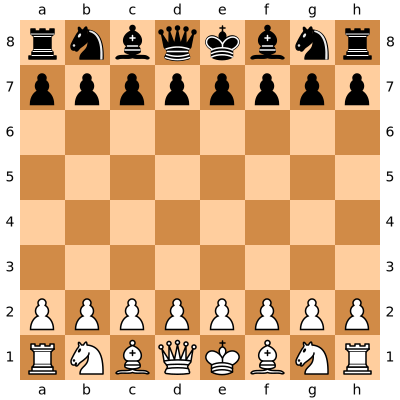

In [13]:
b = Board()
b

In [14]:
b.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

In [15]:
#    +
#    N
# -W   E+
#    S
#    -
DIRECTIONS = ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
WHITE_DIRS, BLACK_DIRS = ['NW', 'N', 'NE'], ['SE', 'S', 'SW'] # Pawn directions
UNDER_PROMOS = [ROOK, BISHOP, KNIGHT]
def deltas2dir(dx, dy):
    if dx > 0 and dy == 0:
        return 'E'
    elif dx > 0 and dy > 0:
        return 'NE'
    elif dx == 0 and dy > 0:
        return 'N'
    elif dx < 0 and dy > 0:
        return 'NW'
    elif dx < 0 and dy == 0:
        return 'W'
    elif dx < 0 and dy < 0:
        return 'SW'
    elif dx == 0 and dy < 0:
        return 'S'
    elif dx > 0 and dy < 0:
        return 'SE'
    else:
        raise ValueError('dx and dy cannot both be 0')


# Since our NN will output an 73x8x8 policy vector we will use these to translate 
# between NN and Board interpretation of a move
def delta2idx(x, y, dx, dy, promotion):
    distance, direction = max(abs(dx), abs(dy)), deltas2dir(dx, dy)
    if promotion in UNDER_PROMOS: # Pawn underpromotion
        assert y in (6, 1)
        z = UNDER_PROMOS.index(promotion) * 3 + 64 + \
            (WHITE_DIRS if y == 6 else BLACK_DIRS).index(direction)
    elif {abs(dx), abs(dy)} == {1, 2}: # Knight move
        z = (((abs(dx) == 2) << 2) | ((dx > 0) << 1) | (dy > 0)) + 56
    else: # Queen move or promo to Queen
        z = DIRECTIONS.index(direction) * 7 + distance - 1
    return x, y, z


def move2idx(move):
    x, y = move.from_square % 8, move.from_square // 8
    dx, dy = move.to_square % 8 - x, move.to_square // 8 - y
    return delta2idx(x, y, dx, dy, move.promotion)

xy2uci = lambda x, y: 'abcdefgh'[x] + str(y+1)


def idx2move(board, x, y, z):
    if z < 56: # Queen move or promo to Queen
        distance = z % 7 + 1
        direction = DIRECTIONS[z // 7]
        dx = distance * (-1 if 'W' in direction else 1 if 'E' in direction else 0)
        dy = distance * (-1 if 'S' in direction else 1 if 'N' in direction else 0)
        promo = 'q' if board.piece_at(x + y * 8).piece_type == PAWN and (y + dy in (0, 7)) else ''
    elif z < 64: # Knight move
        z -= 56
        dx = 2 if ((z >> 2) & 1) else 1
        dy = 2 if dx == 1 else 1
        dx *= 1 if ((z >> 1) & 1) else -1
        dy *= 1 if ((z >> 0) & 1) else -1
        promo = ''
    elif z < 73: # Pawn underpromotion
        assert y in (6, 1)
        z -= 64
        direction = (WHITE_DIRS if y == 6 else BLACK_DIRS)[z % 3]
        promo = UNDER_PROMOS[z // 3]
        promo = 'r' if promo == ROOK else 'n' if promo == KNIGHT else 'b'
        dx = -1 if 'W' in direction else 1 if 'E' in direction else 0
        dy = -1 if 'S' in direction else 1 if 'N' in direction else 0
    else: # WTF
        raise ValueError('Invalid z >= 73. z = %d.' % z)

    return Move.from_uci(xy2uci(x, y) + xy2uci(x+dx, y+dy) + promo)


piece2plane = {val: idx for idx, val in enumerate([
    (WHITE, PAWN),
    (WHITE, ROOK),
    (WHITE, KNIGHT),
    (WHITE, BISHOP),
    (WHITE, QUEEN),
    (WHITE, KING),
    (BLACK, PAWN),
    (BLACK, ROOK),
    (BLACK, KNIGHT),
    (BLACK, BISHOP),
    (BLACK, QUEEN),
    (BLACK, KING),
    (WHITE, 'has_kingside_castling_rights'),
    (WHITE, 'has_queenside_castling_rights'),
    (BLACK, 'has_kingside_castling_rights'),
    (BLACK, 'has_queenside_castling_rights'),
    'turn'
])}


def get_illegal_mask(board):
    tensor = torch.ones([73, 8, 8], dtype=torch.float32)
    for x, y, z in (move2idx(m) for m in board.legal_moves):
        tensor[z][x][y] = 0
    return tensor


def get_attack_graph(board):
    tensor = torch.zeros([64*3, 8, 8], dtype=torch.float32) # Only need 64 because we are not considering promos
    for x, y in itertools.product(range(8), range(8)):
        attacker = board.piece_at(x+y*8)
        for to_square in board.attacks(x+y*8):
            dx, dy = to_square % 8 - x, to_square // 8 - y
            tx, ty, tz = delta2idx(x, y, dx, dy, None)
            tensor[tz][tx][ty] = 1
            target = board.piece_at(x+dx + (y+dy)*8)
            if attacker and target:
                dtz = 64 if attacker.color == WHITE else 64*2
                tensor[tz+dtz][tx][ty] = 1 if attacker.color == target.color else -1
            
    return tensor


def board2tensor(board): # TODO: Could this be bugged? How can we find out?
    tensor = torch.zeros([len(piece2plane), 8, 8], dtype=torch.float32)
    
    # 12 Planes for each piece/color combination
    for x, y in itertools.product(range(8), range(8)):
        sqr = x + y*8
        piece = board.piece_at(sqr)
        if not piece: continue
        plane = piece2plane[(piece.color, piece.piece_type)]
        tensor[plane][x][y] = 1
    
    # 4 planes for castling rights
    combinations = itertools.product((WHITE, BLACK), (board.has_queenside_castling_rights, board.has_kingside_castling_rights))
    for color, func in combinations:
        if func(color):
            plane = piece2plane[(color, func.__name__)]
            tensor[plane,:,:] = 1
    
    # 1 plane is 1 if it is BLACK's turn to move, else 0 if WHITE's turn
    if board.turn == BLACK:
        plane = piece2plane['turn']
        tensor[plane,:,:] = 1
    
    return tensor


def state2policy(board, best_move_idx):
    tensor = torch.zeros([73, 8, 8], dtype=torch.float32)
#     for x, y, z in (move2idx(m) for m in board.legal_moves):
#         tensor[z][x][y] = 1
    
    x, y, z = best_move_idx
    tensor[z][x][y] = 1               # Make the best move worth more
    return tensor / torch.sum(tensor) # Turn tensor into probabilities (sum(tensor) == 1)


In [16]:
print(len(df))
def game2permove(d):
    result, moves = d
    data = []
    result = result.strip()
    moves = sum([m.strip().split() for m in re.split(r'[0-9]+\. ', moves) if m], [])
    # value of state from player's perspective 
    # 1 from winner's perspective, -1 from loser's perspective, 0 if tie
    value = 1 if result == '1-0' else -1 if result == '0-1' else 0
    board = Board()
    for move_str in moves:
        move = board.parse_san(move_str)
        
        assert idx2move(board, *move2idx(move)) == move

        # Store data point
#         state_data.append(board.fen())
#         value_data.append(value)
#         move_data.append(move_str)
        data.append((board.fen(), value, move_str))

        # Move to next data point
        board.push(move)

        value *= -1
    
    return data

state_data, value_data, move_data = [], [], []
with Pool() as pool:
    games = pool.map(game2permove, zip(df.result, df.moves), chunksize=32)
    print(len(games))
    for gamedata in games:
        for sd, vd, md in gamedata:
            state_data.append(sd)
            value_data.append(vd)
            move_data.append(md)
    
permove_df = pd.DataFrame(data={'state': state_data, 'value': value_data, 'move': move_data})

# #Make even number of win/loss/tie
# res2count = {r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)}
# print(res2count)
# least = min(res2count.values())
# rows, counts = [], {-1:0, 0:0, 1:0}
# for state, value, move in zip(permove_df.state, permove_df.value, permove_df.move):
#     if counts[value] >= least: continue
#     counts[value] += 1
#     rows.append([state, value, move])
# permove_df = pd.DataFrame(rows, columns=['state', 'value', 'move'])
# del rows

print({r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)})


permove_df.to_csv(PROCESSED_FNAME)

120606
120606
{-1: 4550184, 1: 4552926, 0: 1376085}


In [16]:
permove_df = pd.read_csv(PROCESSED_FNAME)

In [17]:
permove_df.head()

,Unnamed: 0,state,value,move
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,c4
1,1,rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,0,c5
2,2,rnbqkbnr/pp1ppppp/8/2p5/2P5/8/PP1PPPPP/RNBQKBN...,0,Nf3
3,3,rnbqkbnr/pp1ppppp/8/2p5/2P5/5N2/PP1PPPPP/RNBQK...,0,e6
4,4,rnbqkbnr/pp1p1ppp/4p3/2p5/2P5/5N2/PP1PPPPP/RNB...,0,g3


In [18]:
print({r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)})
n_rows = permove_df.shape[0]
print(n_rows)

{-1: 4550184, 1: 4552926, 0: 1376085}
10479195


In [205]:
permove_df = permove_df[permove_df.value != 0]
print({r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)})
n_rows = permove_df.shape[0]
print(n_rows)

{-1: 4550184, 1: 4552926, 0: 0}
9103110


In [47]:
from collections import defaultdict
counts = defaultdict(int)
for i, (state, value) in enumerate(zip(permove_df.state, permove_df.value)):
    key = ('white' if Board(state).turn == WHITE else 'black', value)
    counts[key] += 1
    if i % 100000 == 0 and i != 0:
        print(counts)
print(counts)

defaultdict(<class 'int'>, {('white', 0): 8357, ('black', 0): 8272, ('white', 1): 22417, ('black', -1): 22218, ('white', -1): 19454, ('black', 1): 19283})
defaultdict(<class 'int'>, {('white', 0): 18397, ('black', 0): 18230, ('white', 1): 44054, ('black', -1): 43659, ('white', -1): 37989, ('black', 1): 37672})
defaultdict(<class 'int'>, {('white', 0): 23790, ('black', 0): 23573, ('white', 1): 67849, ('black', -1): 67240, ('white', -1): 59029, ('black', 1): 58520})
defaultdict(<class 'int'>, {('white', 0): 29367, ('black', 0): 29107, ('white', 1): 91025, ('black', -1): 90206, ('white', -1): 80504, ('black', 1): 79792})
defaultdict(<class 'int'>, {('white', 0): 35400, ('black', 0): 35085, ('white', 1): 113341, ('black', -1): 112349, ('white', -1): 102366, ('black', 1): 101460})
defaultdict(<class 'int'>, {('white', 0): 43777, ('black', 0): 43389, ('white', 1): 135397, ('black', -1): 134211, ('white', -1): 122155, ('black', 1): 121072})
defaultdict(<class 'int'>, {('white', 0): 52713, ('b

KeyboardInterrupt: 

In [206]:
class SupervisedChessDataset(Dataset):
    
    def get_raw(self, idx):
        row = self.df.iloc[idx,:]
        state, value, move = row.state, row.value, row.move
        board = Board(state)
        move = board.parse_san(move)
        return {'board': board,
                'value': value,
                'move': move,
               }
    
    def __init__(self, df, idxs):
        self.df = df.iloc[idxs]
        self.length = self.df.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        state, value, move = row.state, row.value, row.move
        board = Board(state)
        move_idxs = move2idx(board.parse_san(move))
        illegal_mask = get_illegal_mask(board)
        # attack_graph = get_attack_graph(board)
        return {'state': board2tensor(board), # torch.cat((board2tensor(board), attack_graph), 0),
                'value': torch.Tensor([value]),
                'policy': state2policy(board, move_idxs),
                'illegal_mask': illegal_mask,
               }


class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(256, 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
        ]))
        self.relu_out = nn.LeakyReLU()
        
    def forward(self, x):
        conv_out = self.net(x)
        return self.relu_out(conv_out + x)

    
class Flatten(nn.Module):
    def forward(self, x):
        return x.flatten(1)

    
class ChessNet(nn.Module):
    def __init__(self, n_res_blocks=19, learning_rate=0.01, bias=False, gpu_id=0):
        super(ChessNet, self).__init__()
        res_blocks = [(f'res_block{i+1}', ResBlock()) for i in range(n_res_blocks)]
        self.res_tower = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(len(piece2plane), 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
            ('relu1', nn.LeakyReLU(inplace=True)),
            *res_blocks
        ]))
        self.policy_head = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 64, 1)), # Changed to output 64 filters instead of 2
            ('batchnorm1', nn.BatchNorm2d(64)),
            ('relu1', nn.LeakyReLU()),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(8*8*64, 8*8*73)),
            ('softmax', nn.Softmax(dim=1))
        ]))
        self.value_head = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 1, 1)), # Changed to 32 out instead of 2
            ('batchnorm1', nn.BatchNorm2d(1)),
            ('relu1', nn.LeakyReLU()),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(64 * 1, 512)),
            ('relu2', nn.LeakyReLU()),
            ('fc2', nn.Linear(512, 1)),
            ('tanh', nn.Tanh())
        ]))

        
    def forward(self, x):
        tower_out = self.res_tower(x)
        policy_out = self.policy_head(tower_out)
        value_out = self.value_head(tower_out)
        
        return policy_out.view(-1, 73, 8, 8), value_out
    
def tensor2value(t):
    return [round(v.item(), 1) for v in t]

In [207]:
class ValNet(nn.Module):
    def __init__(self):
        super(ValNet, self).__init__()
        self.p = torch.zeros(73, 8, 8)
        self.f = nn.Sequential(OrderedDict([
            ('flatten', Flatten()),
            ('fc1', nn.Linear(64 * len(piece2plane), 512)),
            ('relu3', nn.LeakyReLU()),
            ('fc2', nn.Linear(512, 1)),
            ('tanh', nn.Tanh())
        ]))
        
    def forward(self, x):
        return torch.zeros(x.size()[0], 73, 8, 8).to(device), self.f(x)

In [208]:
UPDATE_FREQ = 10      # when to print update in number of batches
NL_UPDATE_FREQ = 2000 # when to calculate new chunk of averages and print new line

def fit_epoch(nnet, optimizer, scheduler, policy_criterion, value_criterion,
              POLICY_WEIGHT, VALUE_WEIGHT, train_dl, val_dl, skip_validation=False):
    illegal_criterion, zero_policy = nn.MSELoss(), torch.zeros(1, 73, 8, 8).to(device)
    running_policy_loss, running_value_loss, p_correct, p_total, v_correct, v_total, t0 = 0., 0., 0, 0, 0, 0, time.time()
    v_counter, v_exp = Counter(), Counter()
    nnet.train()
    for i, batch in enumerate(train_dl):
        # Transfer to GPU
        state, policy, value, illegal_mask = batch['state'].to(device), batch['policy'].to(device), \
            batch['value'].to(device), batch['illegal_mask'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        policy_out, value_out = nnet(state)
        policy_loss = (policy_criterion(policy_out, policy) + \
                       illegal_criterion(policy_out * illegal_mask, zero_policy))* POLICY_WEIGHT
        value_loss  = value_criterion(value_out, value) * VALUE_WEIGHT
        total_loss = policy_loss + value_loss
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_policy_loss += policy_loss.item()
        running_value_loss  += value_loss.item()
        p_correct += sum(policy.flatten(1).argmax(1) == policy_out.flatten(1).argmax(1)).item()
        p_total += policy.size()[0]
        v_correct += sum([(vp >= 0 and ve > 0) or (vp <= 0 and ve < 0) for vp, ve in zip(value_out, value)]).item()
        v_total += (value != 0).sum().item()
        v_counter.update([round(v.item(), 1) for v in value_out])
        v_exp.update([round(v.item(), 1) for v in value])
        denom = i % NL_UPDATE_FREQ + 1
        nl = denom == NL_UPDATE_FREQ or i == len(train_dl)
        if i % UPDATE_FREQ == UPDATE_FREQ - 1:    # print every UPDATE_FREQ mini-batches
            vcs, s = [0 for _ in range(21)], 0
            for v, count in v_counter.items():
                vcs[int(v*10) + 10] = count
                s += count
            vcs = [f'{vc/s:.3f}'[2:] for vc in vcs]
            print('[%d,%7d] (%6.2fs) pol_acc: %.2f%% val_acc: %.2f%% policy_loss: %.4e value_loss: %.4e total_loss: %.4e lrs: %s   value_dist %s exp_dist %s                   ' %
                  (epoch + 1, i + 1, time.time() - t0, p_correct*100./p_total, v_correct*100./v_total, 
                   running_policy_loss / denom, running_value_loss / denom,
                   (running_policy_loss + running_value_loss) / denom, scheduler.get_lr(), ' '.join(vcs), 
                   ' '.join([f'{v_exp[x]/sum(v_exp.values()):.3f}'[2:] for x in [-1, 0, 1]])),
                  end='\n' if nl else '\r')
        
        if nl:
            running_policy_loss, running_value_loss, p_correct, p_total, v_correct, v_total, t0 = 0., 0., 0, 0, 0, 0, time.time()
            v_counter, v_exp = Counter(), Counter()
        
        scheduler.step()

    if skip_validation:
        return None

    # Validation
    nnet.eval()
    correct, total, value_loss_total, policy_loss_total = 0, 0, 0.0, 0.0
    values, value_exp = [], []
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(val_dl):
            # Transfer to GPU
            state, policy, value, illegal_mask = batch['state'].to(device), batch['policy'].to(device), \
                batch['value'].to(device), batch['illegal_mask'].to(device)
            policy_out, value_out = nnet(state)
            policy_loss = (policy_criterion(policy_out, policy) + \
                           illegal_criterion(policy_out * illegal_mask, zero_policy))* POLICY_WEIGHT
            value_loss  = value_criterion(value_out, value) * VALUE_WEIGHT

            correct += sum(policy.flatten(1).argmax(1) == policy_out.flatten(1).argmax(1)).item()
            total += policy.size()[0]
            value_loss_total += value_loss.item()
            policy_loss_total += policy_loss.item()
            
            values.extend([v.item() for v in value_out])
            value_exp.extend([v.item() for v in value])
            
    acc = correct/total
    avg_value_loss = value_loss_total/len(val_dl)
    avg_policy_loss = policy_loss_total/len(val_dl)
    avg_loss = avg_value_loss + avg_policy_loss
    
    matplotlib.rcParams['figure.figsize'] = [15, 10]

    for i in range(4):
        filt = [-1, 0, 1] if i == 0 else [[0], [-1], [1]][i-1]
        ax = plt.subplot(2, 2, i+1)
        ax.hist([v for v, exp in zip(values, value_exp) if exp in filt], bins=200, color='blue', edgecolor='black')
        ax.set_title(f'Histogram of predicted values in {filt}', size=20)
        ax.set_xlabel('Predicted value (win=1, loss=-1, tie=0)', size=17)
        ax.set_ylabel('Frequency', size=17)

    plt.tight_layout()
    plt.show()
    print(f'VALIDATION RESULTS: accuracy: {acc*100:.3f}%, total loss: {avg_loss:.3e}, policy loss: {avg_policy_loss:.3e}, value_loss: {avg_value_loss:.3e}' + (' '*300))
    print()

    return avg_loss

In [222]:
nnet = ChessNet(n_res_blocks=19)
nnet.to(device)
print()
# if os.path.exists(MODEL_PATH):
#     nnet.load_state_dict(torch.load(MODEL_PATH))

data = train_ds[0]
state, policy, value = data['state'].to(device), data['policy'].to(device), data['value'].to(device)
x = state.unsqueeze(0)
policy, value = nnet.forward(x)
print(x.size(), '->', (policy.size(), value.size()))

In [223]:
BATCH_SIZE = 16
np.random.seed(42)
idxs = np.arange(n_rows)
np.random.shuffle(idxs)
train, val, test = idxs[:int(n_rows*.9)], idxs[int(n_rows*.9):int(n_rows*.95)], idxs[int(n_rows*.95):]
print((len(train), len(val), len(test)))
train_ds, val_ds, test_ds = [SupervisedChessDataset(permove_df, idxs)
                             for idxs in [train, val, test]]
train_dl, val_dl, test_dl = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
                             for ds in [train_ds, val_ds, test_ds]]

(8192799, 455155, 455156)


In [ ]:
EPOCHS = 2
policy_criterion = nn.BCELoss()
value_criterion = nn.SmoothL1Loss()
VALUE_WEIGHT = .01
POLICY_WEIGHT = 0

optimizer = optim.SGD(nnet.parameters(), lr=1e-1, momentum=0.9)#, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200000, 400000, 550000, 650000], gamma=0.1)

best_loss = float('inf')
scheduler.get_lr(), best_loss

([0.1], inf)

In [ ]:
for epoch in range(EPOCHS):
    val_loss = fit_epoch(nnet, optimizer, scheduler, policy_criterion, value_criterion, 
                         POLICY_WEIGHT, VALUE_WEIGHT, train_dl, val_dl)
    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model!')
        torch.save(nnet.state_dict(), MODEL_PATH)

[1,   2000] ( 75.73s) pol_acc: 0.00% val_acc: 51.57% policy_loss: 0.0000e+00 value_loss: 5.0124e-03 total_loss: 5.0124e-03 lrs: [0.1]   value_dist 000 001 001 001 002 004 009 030 081 151 346 322 029 013 005 002 001 001 000 000 000 exp_dist 500 000 500                   
[1,   4000] ( 71.02s) pol_acc: 0.02% val_acc: 52.36% policy_loss: 0.0000e+00 value_loss: 4.9845e-03 total_loss: 4.9845e-03 lrs: [0.1]   value_dist 000 000 000 000 000 001 004 023 121 237 251 340 022 001 000 000 000 000 000 000 000 exp_dist 504 000 496                   


In [27]:
nnet.eval()
p_correct, values, value_losses, value_exp, total, value_loss_total, policy_loss_total = 0, [], [], [], 0, 0.0, 0.0
with torch.set_grad_enabled(False):
    for i, batch in enumerate(test_dl):
        # Transfer to GPU
        state, policy, value = batch['state'].to(device), batch['policy'].to(device), batch['value'].to(device)
        policy_out, value_out = nnet(state)
        policy_loss = policy_criterion(policy_out, policy)
        value_loss  = value_criterion(value_out, value)

        p_correct += sum(policy.flatten(1).argmax(1) == policy_out.flatten(1).argmax(1)).item()
        total += policy.size()[0]
        value_loss_total += value_loss.item()
        policy_loss_total += policy_loss.item()
        
        value_losses.append(value_loss.item())
        values.extend([v.item() for v in value_out])
        value_exp.extend([v.item() for v in value])


In [102]:
val_p_correct = sum([(vp >= 0 and ve >= 0) or (vp <= 0 and ve <= 0) for vp, ve in zip(values, value_exp) if ve != 0])*100./len(values)
val_p_close = sum([(vp >= -.05 and ve >= 0) or (vp <= .05 and ve <= 0) for vp, ve in zip(values, value_exp)])*100./len(values)
val_p_far = sum([(vp <= -.10 and ve >= 0) or (vp >= .10 and ve <= 0) for vp, ve in zip(values, value_exp)])*100./len(values)
val_p_correct_cls = sum([round(vp) == round(ve) for vp, ve in zip(values, value_exp)])*100./len(values)
print(f'{val_p_correct:.5f}% of values are predicted on the same side of 0 as expected.')
print(f'{val_p_close:.5f}% of values are predicted on the same side of 0 or CLOSE as expected.')
print(f'{val_p_correct_cls:.5f}% of values are predicted the same class as expected.')
print(f'{val_p_far:.5f}% of values are predicted FAR from the true label.')

55.05491% of values are predicted on the same side of 0 as expected.
79.28140% of values are predicted on the same side of 0 or CLOSE as expected.
34.19872% of values are predicted the same class as expected.
27.11377% of values are predicted FAR from the true label.


# Seperately trained:
79.87631% of values are predicted on the same side of 0 as expected.

83.02791% of values are predicted on the same side of 0 or CLOSE as expected.

46.31269% of values are predicted the same class as expected.

# These come from training both model heads simultaneously

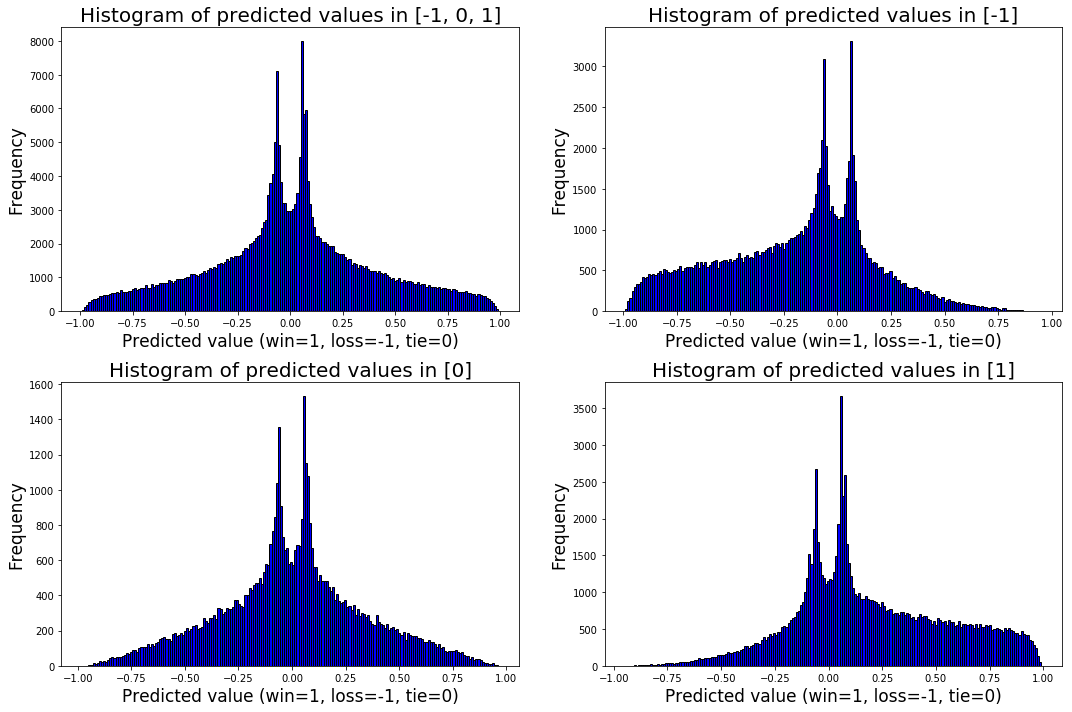

In [30]:
matplotlib.rcParams['figure.figsize'] = [15, 10]

for i in range(4):
    filt = [-1, 0, 1] if i == 0 else [i-2]
    ax = plt.subplot(2, 2, i+1)
    ax.hist([v for v, exp in zip(values, value_exp) if exp in filt], bins=200, color='blue', edgecolor='black')
    ax.set_title(f'Histogram of predicted values in {filt}', size=20)
    ax.set_xlabel('Predicted value (win=1, loss=-1, tie=0)', size=17)
    ax.set_ylabel('Frequency', size=17)

plt.tight_layout()
plt.show()

# These come from training the value head first, and then the policy head

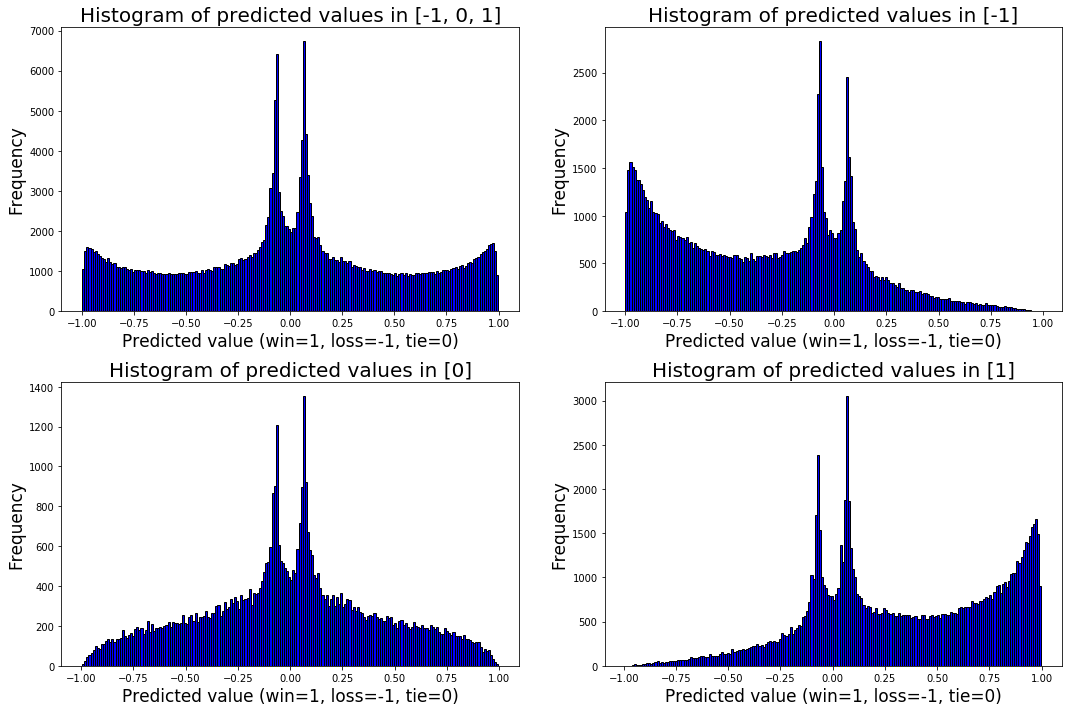

In [79]:
matplotlib.rcParams['figure.figsize'] = [15, 10]

for i in range(4):
    filt = [-1, 0, 1] if i == 0 else [i-2]
    ax = plt.subplot(2, 2, i+1)
    ax.hist([v for v, exp in zip(values, value_exp) if exp in filt], bins=200, color='blue', edgecolor='black')
    ax.set_title(f'Histogram of predicted values in {filt}', size=20)
    ax.set_xlabel('Predicted value (win=1, loss=-1, tie=0)', size=17)
    ax.set_ylabel('Frequency', size=17)

plt.tight_layout()
plt.show()

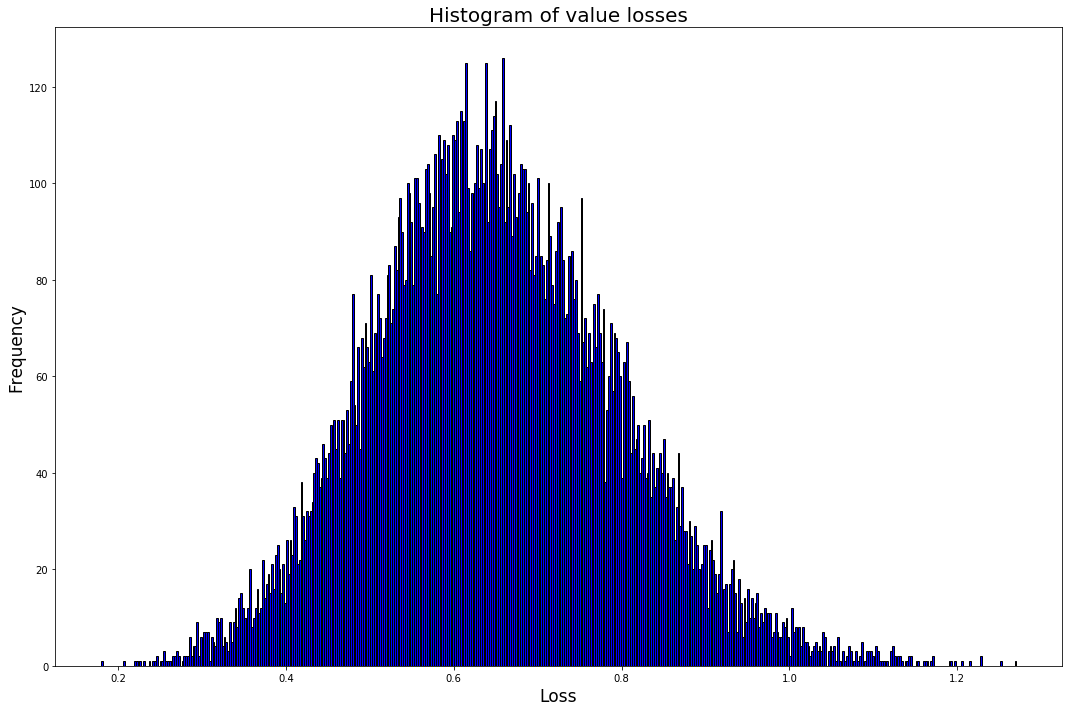

In [31]:
ax = plt.subplot(1, 1, 1)
ax.hist(value_losses, bins=500, color='blue', edgecolor='black')
ax.set_title('Histogram of value losses', size=20)
ax.set_xlabel('Loss', size=17)
ax.set_ylabel('Frequency', size=17)

plt.tight_layout()
plt.show()

In [88]:
# Train only the policy head
nnet.load_state_dict(torch.load('models/valueonly.sd'))
for param in nnet.parameters():
    param.requires_grad = False
for param in nnet.policy_head.parameters():
    param.requires_grad = True

EPOCHS = 2
policy_criterion = nn.BCELoss()
value_criterion = nn.MSELoss()
VALUE_WEIGHT = 0.
POLICY_WEIGHT = 2.

# optimizer = optim.SGD(nnet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
optimizer = optim.SGD(
    [
        {"params": nnet.res_tower.parameters(),   "lr": 0.}, # maybe try with this value inbetween policy LR and value LR
        {"params": nnet.policy_head.parameters(), "lr": 0.2},
        {"params": nnet.value_head.parameters(),  "lr": 0.0},
    ],
    lr=0, momentum=0.9, weight_decay=1e-5
)
best_loss = float('inf')
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200000, 400000, 550000, 650000], gamma=0.1)

scheduler.get_lr(), best_loss

([0.0, 0.2, 0.0], inf)

In [89]:
# Fit

[1,   2000] ( 29.10s) policy_loss: 3.9833e-03 value_loss: 0.0000e+00 total_loss: 3.9833e-03 lr: 0.00e+00 Counter({0.1: 3505, -0.1: 3302, -0.0: 2848, 0.9: 1736, -0.9: 1566, -0.2: 1528, 0.2: 1505, -0.8: 1405, -0.3: 1337, 0.8: 1328, 0.3: 1323, 0.7: 1203, -0.7: 1191, 0.4: 1167, -0.4: 1138, 0.6: 1121, -0.6: 1112, -0.5: 1089, 0.5: 1048, -1.0: 776, 1.0: 772}) expected=Counter({1.0: 12923, -1.0: 12893, 0.0: 6184})                
[1,   4000] ( 26.86s) policy_loss: 3.7878e-03 value_loss: 0.0000e+00 total_loss: 3.7878e-03 lr: 0.00e+00 Counter({-0.1: 3401, 0.1: 3383, -0.0: 2823, -0.9: 1691, 0.9: 1643, 0.2: 1553, -0.2: 1506, 0.8: 1335, -0.8: 1321, 0.3: 1300, -0.3: 1261, 0.7: 1214, -0.7: 1167, -0.6: 1153, -0.5: 1153, 0.4: 1149, -0.4: 1148, 0.5: 1125, 0.6: 1104, -1.0: 792, 1.0: 778}) expected=Counter({-1.0: 12921, 1.0: 12762, 0.0: 6317})                
[1,   6000] ( 26.89s) policy_loss: 3.6159e-03 value_loss: 0.0000e+00 total_loss: 3.6159e-03 lr: 0.00e+00 Counter({0.1: 3530, -0.1: 3297, -0.0: 2861,

[1,  78000] ( 26.83s) policy_loss: 3.0368e-03 value_loss: 0.0000e+00 total_loss: 3.0368e-03 lr: 0.00e+00 Counter({0.1: 3372, -0.1: 3246, 0.0: 2878, -0.9: 1768, 0.9: 1741, 0.2: 1577, -0.2: 1568, 0.8: 1306, -0.3: 1299, 0.3: 1276, -0.8: 1270, -0.7: 1197, 0.7: 1160, -0.4: 1149, 0.4: 1143, 0.6: 1129, -0.6: 1120, -0.5: 1105, 0.5: 1096, -1.0: 833, 1.0: 767}) expected=Counter({-1.0: 13075, 1.0: 12742, 0.0: 6183})                
[1,  80000] ( 26.82s) policy_loss: 3.0292e-03 value_loss: 0.0000e+00 total_loss: 3.0292e-03 lr: 0.00e+00 Counter({0.1: 3486, -0.1: 3323, -0.0: 2818, -0.9: 1704, 0.9: 1636, -0.2: 1576, 0.2: 1480, 0.3: 1386, 0.8: 1356, -0.3: 1344, -0.8: 1313, -0.7: 1219, 0.7: 1191, -0.4: 1162, -0.5: 1122, 0.5: 1108, -0.6: 1103, 0.4: 1099, 0.6: 1059, 1.0: 772, -1.0: 743}) expected=Counter({-1.0: 12956, 1.0: 12771, 0.0: 6273})                
[1,  82000] ( 26.81s) policy_loss: 3.0227e-03 value_loss: 0.0000e+00 total_loss: 3.0227e-03 lr: 0.00e+00 Counter({0.1: 3449, -0.1: 3296, -0.0: 2839, 

[1, 154000] ( 27.10s) policy_loss: 2.9807e-03 value_loss: 0.0000e+00 total_loss: 2.9807e-03 lr: 0.00e+00 Counter({0.1: 3390, -0.1: 3312, -0.0: 2855, 0.9: 1694, -0.9: 1660, 0.2: 1594, -0.2: 1530, 0.8: 1328, -0.3: 1324, -0.8: 1299, 0.3: 1273, -0.7: 1185, -0.6: 1160, -0.4: 1155, -0.5: 1149, 0.4: 1138, 0.6: 1125, 0.5: 1109, 0.7: 1104, 1.0: 812, -1.0: 804}) expected=Counter({1.0: 12974, -1.0: 12847, 0.0: 6179})                
[1, 156000] ( 27.98s) policy_loss: 2.9778e-03 value_loss: 0.0000e+00 total_loss: 2.9778e-03 lr: 0.00e+00 Counter({0.1: 3519, -0.1: 3283, 0.0: 2765, 0.9: 1708, -0.9: 1680, 0.2: 1624, -0.2: 1516, -0.8: 1346, 0.3: 1339, 0.8: 1311, -0.3: 1269, -0.7: 1179, -0.5: 1164, -0.4: 1152, -0.6: 1146, 0.4: 1141, 0.5: 1140, 0.7: 1134, 0.6: 1077, -1.0: 761, 1.0: 746}) expected=Counter({1.0: 12885, -1.0: 12841, 0.0: 6274})                
[1, 158000] ( 27.59s) policy_loss: 2.9881e-03 value_loss: 0.0000e+00 total_loss: 2.9881e-03 lr: 0.00e+00 Counter({0.1: 3367, -0.1: 3334, 0.0: 2868, 0

[1, 230000] ( 26.88s) policy_loss: 2.9385e-03 value_loss: 0.0000e+00 total_loss: 2.9385e-03 lr: 0.00e+00 Counter({0.1: 3498, -0.1: 3242, 0.0: 2890, -0.9: 1753, 0.9: 1678, 0.2: 1585, -0.2: 1477, 0.3: 1356, -0.3: 1334, 0.8: 1330, -0.8: 1320, -0.7: 1202, 0.7: 1188, 0.4: 1180, -0.6: 1138, -0.4: 1113, 0.5: 1107, -0.5: 1056, 0.6: 1032, -1.0: 808, 1.0: 713}) expected=Counter({-1.0: 12920, 1.0: 12869, 0.0: 6211})                
[1, 232000] ( 26.88s) policy_loss: 2.9444e-03 value_loss: 0.0000e+00 total_loss: 2.9444e-03 lr: 0.00e+00 Counter({0.1: 3420, -0.1: 3306, 0.0: 2820, 0.9: 1745, 0.2: 1609, -0.9: 1590, -0.2: 1497, 0.8: 1355, -0.8: 1353, -0.3: 1302, 0.3: 1229, -0.4: 1227, 0.4: 1204, -0.7: 1173, 0.6: 1152, -0.6: 1137, 0.7: 1129, -0.5: 1104, 0.5: 1088, -1.0: 784, 1.0: 776}) expected=Counter({1.0: 12955, -1.0: 12758, 0.0: 6287})                
[1, 234000] ( 26.82s) policy_loss: 2.9476e-03 value_loss: 0.0000e+00 total_loss: 2.9476e-03 lr: 0.00e+00 Counter({0.1: 3283, -0.1: 3255, -0.0: 2952, 0

[1, 306000] ( 26.79s) policy_loss: 2.9437e-03 value_loss: 0.0000e+00 total_loss: 2.9437e-03 lr: 0.00e+00 Counter({0.1: 3406, -0.1: 3313, 0.0: 2914, -0.9: 1680, 0.9: 1668, 0.2: 1577, -0.2: 1548, 0.8: 1348, -0.8: 1329, 0.3: 1317, -0.3: 1279, -0.4: 1203, -0.7: 1181, -0.6: 1142, 0.7: 1132, 0.4: 1125, -0.5: 1113, 0.5: 1100, 0.6: 1078, -1.0: 790, 1.0: 757}) expected=Counter({-1.0: 12935, 1.0: 12772, 0.0: 6293})                
[1, 308000] ( 26.74s) policy_loss: 2.9448e-03 value_loss: 0.0000e+00 total_loss: 2.9448e-03 lr: 0.00e+00 Counter({0.1: 3440, -0.1: 3292, -0.0: 2811, -0.9: 1739, 0.9: 1714, -0.2: 1580, 0.2: 1543, 0.8: 1375, -0.8: 1332, 0.3: 1267, -0.3: 1262, -0.4: 1176, -0.5: 1175, -0.7: 1173, 0.4: 1145, 0.7: 1139, -0.6: 1106, 0.6: 1101, 0.5: 1071, 1.0: 788, -1.0: 771}) expected=Counter({1.0: 12843, -1.0: 12813, 0.0: 6344})                
[1, 310000] ( 26.74s) policy_loss: 2.9380e-03 value_loss: 0.0000e+00 total_loss: 2.9380e-03 lr: 0.00e+00 Counter({0.1: 3374, -0.1: 3339, -0.0: 2866, 

[2,  70000] ( 26.76s) policy_loss: 2.9282e-03 value_loss: 0.0000e+00 total_loss: 2.9282e-03 lr: 0.00e+00 Counter({-0.1: 3416, 0.1: 3320, -0.0: 2872, 0.9: 1666, -0.9: 1661, -0.2: 1579, 0.2: 1534, -0.8: 1344, 0.8: 1330, -0.3: 1307, 0.3: 1305, 0.4: 1226, 0.7: 1186, -0.4: 1153, -0.7: 1134, -0.5: 1116, 0.5: 1111, -0.6: 1100, 0.6: 1095, -1.0: 782, 1.0: 763}) expected=Counter({-1.0: 12842, 1.0: 12837, 0.0: 6321})                
[2,  72000] ( 26.71s) policy_loss: 2.9351e-03 value_loss: 0.0000e+00 total_loss: 2.9351e-03 lr: 0.00e+00 Counter({0.1: 3468, -0.1: 3363, 0.0: 2810, 0.9: 1655, -0.9: 1655, 0.2: 1583, -0.2: 1498, -0.3: 1351, -0.8: 1318, 0.3: 1316, 0.8: 1306, -0.7: 1292, 0.4: 1183, 0.7: 1175, -0.5: 1148, -0.4: 1139, -0.6: 1078, 0.6: 1017, 0.5: 1017, 1.0: 818, -1.0: 810}) expected=Counter({-1.0: 12995, 1.0: 12817, 0.0: 6188})                
[2,  74000] ( 26.76s) policy_loss: 2.9332e-03 value_loss: 0.0000e+00 total_loss: 2.9332e-03 lr: 0.00e+00 Counter({0.1: 3495, -0.1: 3234, -0.0: 2926, 

[2, 146000] ( 26.76s) policy_loss: 2.9410e-03 value_loss: 0.0000e+00 total_loss: 2.9410e-03 lr: 0.00e+00 Counter({0.1: 3412, -0.1: 3252, 0.0: 2848, 0.9: 1693, -0.9: 1674, -0.2: 1568, 0.2: 1529, 0.8: 1356, -0.8: 1323, -0.3: 1287, 0.3: 1271, -0.7: 1261, -0.6: 1170, 0.7: 1166, -0.5: 1157, 0.4: 1137, 0.5: 1121, -0.4: 1120, 0.6: 1104, -1.0: 801, 1.0: 750}) expected=Counter({-1.0: 12949, 1.0: 12767, 0.0: 6284})                
[2, 148000] ( 26.69s) policy_loss: 2.9357e-03 value_loss: 0.0000e+00 total_loss: 2.9357e-03 lr: 0.00e+00 Counter({0.1: 3461, -0.1: 3331, -0.0: 2767, 0.9: 1704, -0.9: 1695, -0.2: 1568, 0.2: 1539, 0.8: 1365, 0.3: 1331, -0.8: 1295, -0.3: 1269, 0.7: 1201, -0.4: 1197, 0.4: 1169, 0.5: 1154, -0.7: 1146, -0.6: 1142, 0.6: 1082, -0.5: 1070, 1.0: 790, -1.0: 724}) expected=Counter({1.0: 12926, -1.0: 12849, 0.0: 6225})                
[2, 150000] ( 26.79s) policy_loss: 2.9301e-03 value_loss: 0.0000e+00 total_loss: 2.9301e-03 lr: 0.00e+00 Counter({0.1: 3461, -0.1: 3329, 0.0: 2928, 0

[2, 222000] ( 26.70s) policy_loss: 2.9315e-03 value_loss: 0.0000e+00 total_loss: 2.9315e-03 lr: 0.00e+00 Counter({0.1: 3429, -0.1: 3261, -0.0: 2737, 0.9: 1746, -0.9: 1668, -0.2: 1562, 0.2: 1538, 0.8: 1391, -0.3: 1341, -0.8: 1302, 0.3: 1248, -0.7: 1234, 0.7: 1187, 0.4: 1168, 0.5: 1158, -0.4: 1151, -0.6: 1138, 0.6: 1107, -0.5: 1107, -1.0: 774, 1.0: 753}) expected=Counter({-1.0: 12864, 1.0: 12788, 0.0: 6348})                
[2, 224000] ( 26.75s) policy_loss: 2.9294e-03 value_loss: 0.0000e+00 total_loss: 2.9294e-03 lr: 0.00e+00 Counter({0.1: 3437, -0.1: 3261, 0.0: 2747, -0.9: 1676, 0.9: 1668, 0.2: 1598, -0.2: 1578, -0.8: 1353, 0.8: 1337, -0.3: 1329, 0.3: 1290, -0.7: 1206, 0.4: 1190, 0.7: 1177, -0.4: 1154, -0.6: 1148, 0.6: 1147, -0.5: 1129, 0.5: 1025, -1.0: 785, 1.0: 765}) expected=Counter({-1.0: 12889, 1.0: 12791, 0.0: 6320})                
[2, 226000] ( 26.70s) policy_loss: 2.9324e-03 value_loss: 0.0000e+00 total_loss: 2.9324e-03 lr: 0.00e+00 Counter({0.1: 3404, -0.1: 3360, 0.0: 2858, 0

[2, 298000] ( 26.76s) policy_loss: 2.9300e-03 value_loss: 0.0000e+00 total_loss: 2.9300e-03 lr: 0.00e+00 Counter({0.1: 3513, -0.1: 3304, -0.0: 2865, 0.9: 1767, -0.9: 1652, 0.2: 1621, -0.2: 1484, 0.3: 1337, -0.3: 1310, -0.8: 1300, 0.8: 1255, -0.7: 1218, -0.4: 1183, 0.4: 1164, 0.7: 1141, 0.6: 1134, -0.6: 1108, 0.5: 1085, -0.5: 1050, -1.0: 787, 1.0: 722}) expected=Counter({1.0: 12907, -1.0: 12833, 0.0: 6260})                
[2, 300000] ( 26.77s) policy_loss: 2.9284e-03 value_loss: 0.0000e+00 total_loss: 2.9284e-03 lr: 0.00e+00 Counter({0.1: 3422, -0.1: 3373, 0.0: 2852, 0.9: 1725, -0.9: 1685, 0.2: 1518, -0.2: 1488, -0.8: 1367, 0.3: 1344, 0.8: 1317, -0.3: 1295, 0.7: 1205, -0.4: 1190, -0.7: 1166, 0.4: 1112, 0.5: 1098, 0.6: 1094, -0.6: 1092, -0.5: 1087, -1.0: 791, 1.0: 779}) expected=Counter({-1.0: 13055, 1.0: 12751, 0.0: 6194})                
[2, 302000] ( 26.75s) policy_loss: 2.9320e-03 value_loss: 0.0000e+00 total_loss: 2.9320e-03 lr: 0.00e+00 Counter({0.1: 3459, -0.1: 3270, -0.0: 2932, 

[3,  62000] ( 27.05s) policy_loss: 2.9350e-03 value_loss: 0.0000e+00 total_loss: 2.9350e-03 lr: 0.00e+00 Counter({0.1: 3471, -0.1: 3378, 0.0: 2841, -0.9: 1766, 0.9: 1635, -0.2: 1527, 0.2: 1522, 0.8: 1430, 0.3: 1292, -0.3: 1282, -0.8: 1259, 0.4: 1213, 0.7: 1211, -0.7: 1169, -0.4: 1130, 0.6: 1125, -0.6: 1117, 0.5: 1087, -0.5: 1031, 1.0: 781, -1.0: 733}) expected=Counter({1.0: 12907, -1.0: 12759, 0.0: 6334})                
[3,  64000] ( 27.11s) policy_loss: 2.9202e-03 value_loss: 0.0000e+00 total_loss: 2.9202e-03 lr: 0.00e+00 Counter({0.1: 3467, -0.1: 3341, 0.0: 2841, 0.9: 1701, -0.9: 1655, 0.2: 1567, -0.2: 1461, -0.8: 1352, 0.8: 1340, -0.3: 1297, 0.3: 1256, -0.7: 1237, -0.4: 1224, 0.7: 1191, 0.4: 1145, -0.5: 1133, 0.5: 1095, 0.6: 1084, -0.6: 1053, 1.0: 782, -1.0: 778}) expected=Counter({-1.0: 12925, 1.0: 12796, 0.0: 6279})                
[3,  66000] ( 27.09s) policy_loss: 2.9338e-03 value_loss: 0.0000e+00 total_loss: 2.9338e-03 lr: 0.00e+00 Counter({0.1: 3506, -0.1: 3229, 0.0: 2882, 0.

[3, 138000] ( 27.15s) policy_loss: 2.9284e-03 value_loss: 0.0000e+00 total_loss: 2.9284e-03 lr: 0.00e+00 Counter({0.1: 3419, -0.1: 3278, -0.0: 2991, 0.9: 1744, -0.9: 1639, 0.2: 1569, -0.2: 1477, 0.8: 1395, -0.8: 1338, -0.3: 1302, 0.3: 1264, 0.7: 1214, -0.7: 1206, -0.4: 1134, 0.4: 1127, -0.6: 1108, -0.5: 1107, 0.6: 1062, 0.5: 989, 1.0: 841, -1.0: 796}) expected=Counter({1.0: 13016, -1.0: 12861, 0.0: 6123})                
[3, 140000] ( 27.09s) policy_loss: 2.9282e-03 value_loss: 0.0000e+00 total_loss: 2.9282e-03 lr: 0.00e+00 Counter({0.1: 3518, -0.1: 3308, 0.0: 2799, 0.9: 1668, -0.9: 1662, -0.2: 1604, 0.2: 1586, 0.8: 1388, -0.8: 1375, 0.3: 1325, -0.3: 1263, 0.7: 1167, -0.4: 1163, -0.5: 1152, -0.7: 1108, 0.4: 1107, -0.6: 1091, 0.5: 1071, 0.6: 1070, -1.0: 798, 1.0: 777}) expected=Counter({-1.0: 12833, 1.0: 12759, 0.0: 6408})                
[3, 142000] ( 27.09s) policy_loss: 2.9226e-03 value_loss: 0.0000e+00 total_loss: 2.9226e-03 lr: 0.00e+00 Counter({0.1: 3457, -0.1: 3235, 0.0: 2901, 0.

[3, 214000] ( 27.09s) policy_loss: 2.9312e-03 value_loss: 0.0000e+00 total_loss: 2.9312e-03 lr: 0.00e+00 Counter({0.1: 3429, -0.1: 3310, 0.0: 2797, 0.9: 1729, -0.9: 1697, -0.2: 1559, 0.2: 1548, 0.8: 1388, -0.8: 1314, -0.3: 1308, 0.3: 1247, 0.7: 1174, -0.7: 1166, -0.6: 1162, 0.4: 1157, 0.6: 1137, -0.4: 1130, -0.5: 1115, 0.5: 1052, 1.0: 814, -1.0: 767}) expected=Counter({-1.0: 12971, 1.0: 12912, 0.0: 6117})                
[3, 216000] ( 27.13s) policy_loss: 2.9233e-03 value_loss: 0.0000e+00 total_loss: 2.9233e-03 lr: 0.00e+00 Counter({0.1: 3504, -0.1: 3368, 0.0: 2786, 0.9: 1737, -0.9: 1635, 0.2: 1549, -0.2: 1538, 0.3: 1350, 0.8: 1339, -0.3: 1309, -0.8: 1264, 0.4: 1194, 0.7: 1152, -0.7: 1148, -0.4: 1134, 0.6: 1129, -0.5: 1117, -0.6: 1098, 0.5: 1082, -1.0: 806, 1.0: 761}) expected=Counter({1.0: 12935, -1.0: 12770, 0.0: 6295})                
[3, 218000] ( 27.06s) policy_loss: 2.9309e-03 value_loss: 0.0000e+00 total_loss: 2.9309e-03 lr: 0.00e+00 Counter({0.1: 3383, -0.1: 3282, 0.0: 2887, -0

[3, 290000] ( 27.08s) policy_loss: 2.9365e-03 value_loss: 0.0000e+00 total_loss: 2.9365e-03 lr: 0.00e+00 Counter({0.1: 3434, -0.1: 3300, -0.0: 2885, 0.9: 1737, -0.9: 1691, -0.2: 1503, 0.2: 1502, 0.8: 1370, 0.3: 1349, -0.3: 1344, -0.8: 1343, 0.7: 1199, -0.7: 1180, -0.4: 1171, 0.4: 1147, 0.6: 1135, 0.5: 1094, -0.6: 1068, -0.5: 1050, -1.0: 784, 1.0: 714}) expected=Counter({1.0: 12928, -1.0: 12893, 0.0: 6179})                
[3, 292000] ( 27.04s) policy_loss: 2.9271e-03 value_loss: 0.0000e+00 total_loss: 2.9271e-03 lr: 0.00e+00 Counter({0.1: 3498, -0.1: 3226, 0.0: 2799, 0.9: 1694, -0.2: 1609, -0.9: 1592, 0.2: 1530, 0.8: 1345, 0.3: 1338, -0.8: 1327, -0.3: 1312, -0.4: 1205, 0.7: 1201, -0.7: 1196, 0.4: 1185, -0.6: 1135, -0.5: 1128, 0.6: 1062, 0.5: 1045, -1.0: 802, 1.0: 771}) expected=Counter({1.0: 12892, -1.0: 12887, 0.0: 6221})                
[3, 294000] ( 27.04s) policy_loss: 2.9331e-03 value_loss: 0.0000e+00 total_loss: 2.9331e-03 lr: 0.00e+00 Counter({0.1: 3419, -0.1: 3313, -0.0: 2830, 

[4,  54000] ( 27.36s) policy_loss: 2.9289e-03 value_loss: 0.0000e+00 total_loss: 2.9289e-03 lr: 0.00e+00 Counter({0.1: 3419, -0.1: 3264, -0.0: 2913, 0.9: 1694, -0.9: 1659, 0.2: 1543, -0.2: 1518, -0.8: 1401, 0.3: 1367, -0.3: 1304, 0.8: 1261, -0.7: 1213, 0.7: 1192, 0.4: 1169, -0.4: 1153, -0.6: 1147, 0.5: 1145, 0.6: 1085, -0.5: 1022, -1.0: 793, 1.0: 738}) expected=Counter({-1.0: 12819, 1.0: 12818, 0.0: 6363})                
[4,  56000] ( 27.33s) policy_loss: 2.9298e-03 value_loss: 0.0000e+00 total_loss: 2.9298e-03 lr: 0.00e+00 Counter({0.1: 3443, -0.1: 3351, -0.0: 2798, -0.9: 1684, 0.9: 1684, 0.2: 1606, -0.2: 1497, 0.3: 1314, 0.8: 1303, -0.8: 1278, -0.3: 1266, 0.7: 1223, -0.4: 1205, 0.4: 1170, -0.7: 1166, 0.5: 1155, -0.6: 1116, 0.6: 1082, -0.5: 1071, -1.0: 820, 1.0: 768}) expected=Counter({-1.0: 12879, 1.0: 12852, 0.0: 6269})                
[4,  58000] ( 27.25s) policy_loss: 2.9299e-03 value_loss: 0.0000e+00 total_loss: 2.9299e-03 lr: 0.00e+00 Counter({0.1: 3416, -0.1: 3282, -0.0: 2887,

KeyboardInterrupt: 

In [128]:
nnet.eval()
p_correct, total, value_loss_total, policy_loss_total = 0, 0, 0., 0.
values, value_losses, value_exp, policy_losses, correct_policy_investment = [], [], [], [], []
with torch.set_grad_enabled(False):
    for i, batch in enumerate(test_dl):
        # Transfer to GPU
        state, policy, value = batch['state'].to(device), batch['policy'].to(device), batch['value'].to(device)
        policy_out, value_out = nnet(state)
        policy_loss = policy_criterion(policy_out, policy) * POLICY_WEIGHT
        value_loss  = value_criterion(value_out, value) * VALUE_WEIGHT

        p_correct += sum(policy.flatten(1).argmax(1) == policy_out.flatten(1).argmax(1)).item()
        total += policy.size()[0]
        value_loss_total += value_loss.item()
        policy_loss_total += policy_loss.item()

        value_losses.append(value_loss.item())
        policy_losses.append(policy_loss.item())
        
        values.extend([v.item() for v in value_out])
        value_exp.extend([v.item() for v in value])
        correct_policy_investment.extend([p.item() for p in (policy_out.flatten(1) * policy.flatten(1)).max(dim=1)[0]])
        

In [129]:
val_p_correct = sum([(vp >= 0 and ve >= 0) or (vp <= 0 and ve <= 0) for vp, ve in zip(values, value_exp)])*100./len(values)
val_p_close = sum([(vp >= -.05 and ve >= 0) or (vp <= .05 and ve <= 0) for vp, ve in zip(values, value_exp)])*100./len(values)
val_p_correct_cls = sum([round(vp) == round(ve) for vp, ve in zip(values, value_exp)])*100./len(values)
print(f'{val_p_correct:.5f}% of values are predicted on the same side of 0 as expected.')
print(f'{val_p_close:.5f}% of values are predicted on the same side of 0 or CLOSE as expected.')
print(f'{val_p_correct_cls:.5f}% of values are predicted the same class as expected.')

79.83033% of values are predicted on the same side of 0 as expected.
83.18904% of values are predicted on the same side of 0 or CLOSE as expected.
45.84596% of values are predicted the same class as expected.


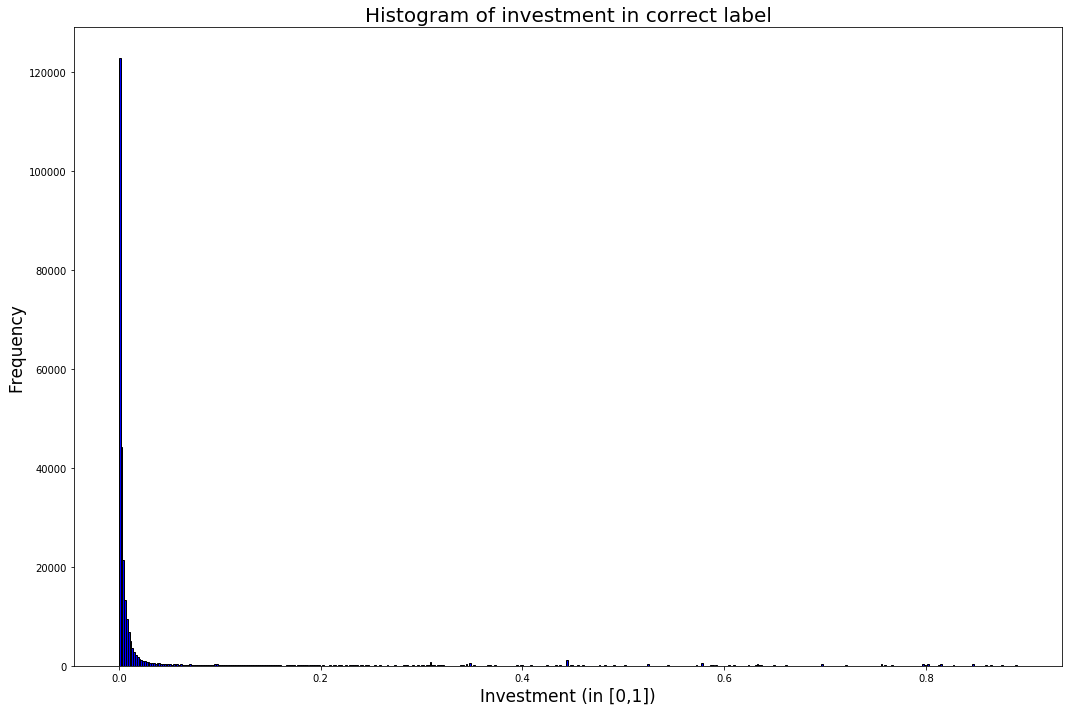

In [131]:
ax = plt.subplot(1, 1, 1)
ax.hist(correct_label_investment, bins=500, color='blue', edgecolor='black')
ax.set_title('Histogram of investment in correct label', size=20)
ax.set_xlabel('Investment (in [0,1])', size=17)
ax.set_ylabel('Frequency', size=17)

plt.tight_layout()
plt.show()

counts = {'WHITE': Counter(), 'BLACK': Counter()}
for i, (state, value) in enumerate(zip(permove_df.state, permove_df.value)):
    board = Board(state)
    col = {WHITE: 'WHITE', BLACK: 'BLACK'}[board.turn]
    counts[col].update([value])
    if i % 100 == 0 or i+1 == len(permove_df):
        print(f'{i/len(permove_df)*100:.1f}% {str(counts)}' + (' '*60), end='\r')
counts

In [32]:
from chess import svg
val2color = lambda v, maxv: '#%02x%02x%02x%02x' % (int(v/maxv*255), 255 - int(v/maxv*255), 255 - int(v/maxv*255), int(v/maxv*255))
val2color = lambda v, maxv: '#%02x%02x%02x%02x' % (int(v/maxv*255), 0, 0, int(v/maxv*255))

def visualize_nn_out(data_idx):
    data = test_ds[data_idx]
    state, value, policy = data['state'].to(device), data['value'].to(device), data['policy'].to(device)
    raw = test_ds.get_raw(data_idx)
    board, player_move = raw['board'], raw['move']
    policy_out, value_out = nnet(state.unsqueeze(0))
    print({WHITE: 'White', BLACK: 'Black'}[board.turn] + "'s turn")
    print(f'Board evaluated to {[f"{v:.5f}" for v in value_out[0]]}, training value is {[f"{v:.5f}" for v in value]}')
    moves_vals = sorted(((policy_out[0][z][x][y].item(), x, y, z, m) 
                         for (x, y, z), m in ((move2idx(m), m) for m in board.legal_moves)), reverse=True)
    arrows = []
    maxv = moves_vals[0][0]
    print(f'The most confident move (reddest) had a value of {maxv:.5f}')
    for v, x, y, z, m in moves_vals:
        arrows.append(svg.Arrow(m.from_square, m.to_square, color=val2color(v, maxv)))

    a = torch.argmax(policy).item()
    print(f"The expected move had a value of {[v for v, x, y, z, m in moves_vals if m == player_move][0]:.5f}")
    # player_move = idx2move(board, (a//8)%8, a%8, a//64)
#     arrows.append(svg.Arrow(player_move.from_square, player_move.to_square, color='#0f0'))
    return svg.board(board=board, arrows=arrows, lastmove=player_move)

Black's turn
Board evaluated to ['0.24918'], training value is ['0.00000']
The most confident move (reddest) had a value of 0.27794
The expected move had a value of 0.27794


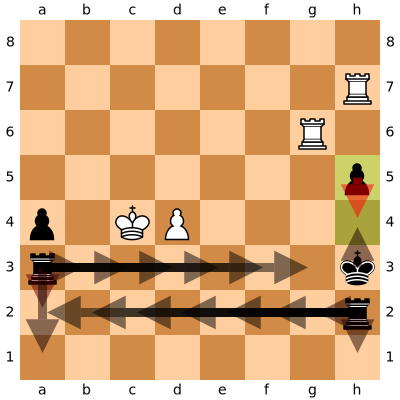

In [33]:
visualize_nn_out(42)

White's turn
Board evaluated to ['-0.71093'], training value is ['-1.00000']
The most confident move (reddest) had a value of 0.02859
The expected move had a value of 0.00091


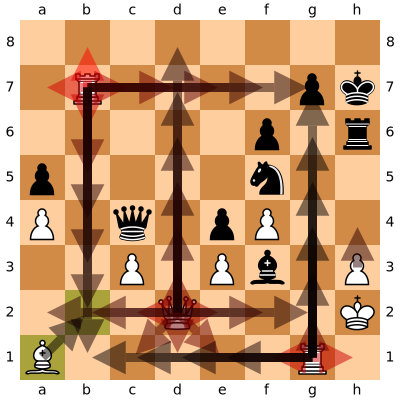

In [34]:
visualize_nn_out(420)

White's turn
Board evaluated to ['0.81979'], training value is ['0.00000']
The most confident move (reddest) had a value of 0.14340
The expected move had a value of 0.14340


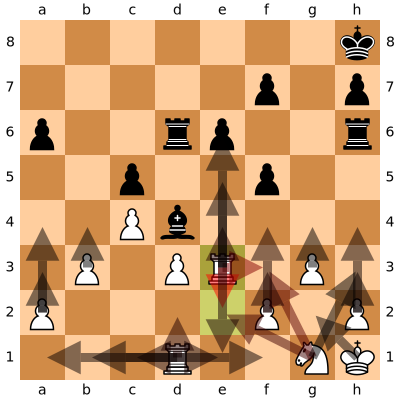

In [35]:
visualize_nn_out(899)

Black's turn
Board evaluated to ['-0.11212'], training value is ['0.00000']
The most confident move (reddest) had a value of 0.13647
The expected move had a value of 0.02853


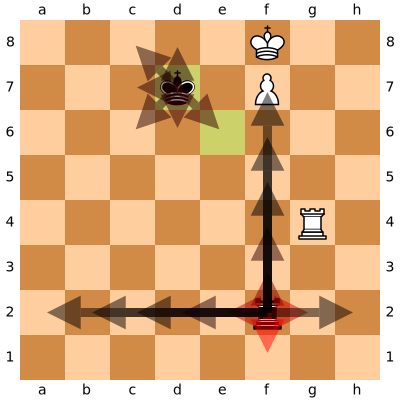

In [36]:
visualize_nn_out(9002)

White's turn
Board evaluated to ['0.69118'], training value is ['1.00000']
The most confident move (reddest) had a value of 0.11949
The expected move had a value of 0.01118


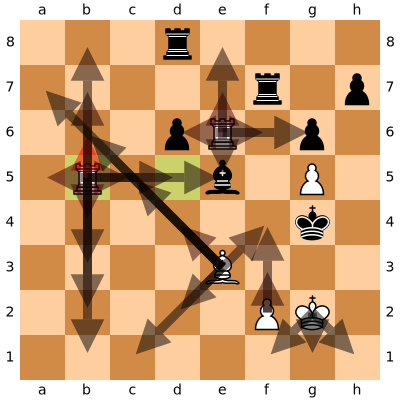

In [37]:
visualize_nn_out(950)

White's turn
Board evaluated to ['0.07026'], training value is ['1.00000']
The most confident move (reddest) had a value of 0.76304
The expected move had a value of 0.76304


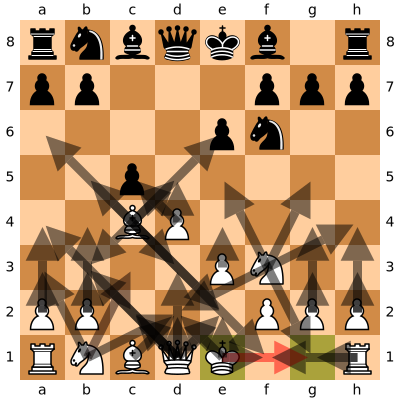

In [38]:
visualize_nn_out(55)

White's turn
Board evaluated to ['0.45240'], training value is ['-1.00000']
The most confident move (reddest) had a value of 0.57863
The expected move had a value of 0.57863


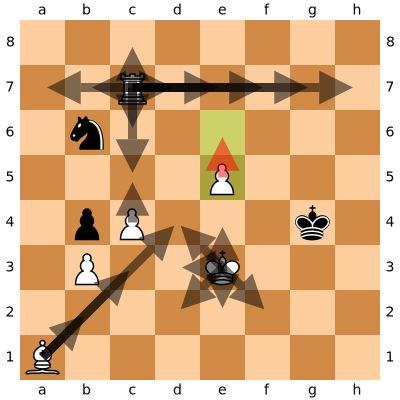

In [39]:
visualize_nn_out(127)

White's turn
Board evaluated to ['0.05975'], training value is ['1.00000']
The most confident move (reddest) had a value of 0.79823
The expected move had a value of 0.79823


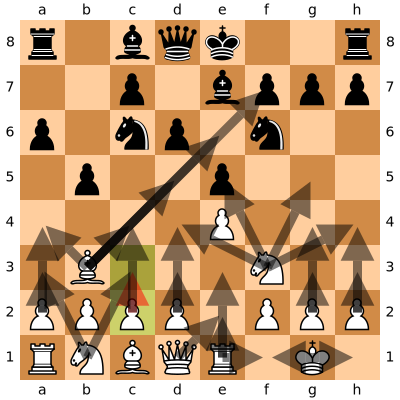

In [102]:
visualize_nn_out(8001)

Black's turn
Board evaluated to ['0.06303'], training value is ['0.00000']
The most confident move (reddest) had a value of 0.00223
The expected move had a value of 0.00200


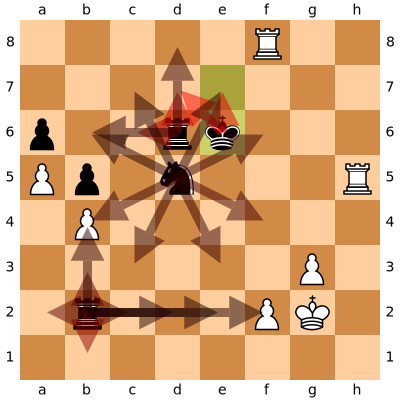

In [103]:
visualize_nn_out(8002)

Black's turn
Board evaluated to ['-0.06781'], training value is ['1.00000']
The most confident move (reddest) had a value of 0.34871
The expected move had a value of 0.34408


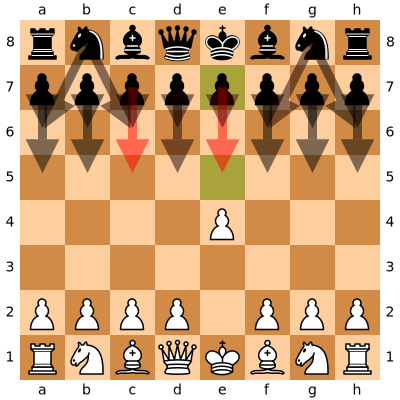

In [104]:
visualize_nn_out(1000)

In [140]:
nnet.load_state_dict(torch.load('models/sep_trained_heads.sd'))
nnet.eval()
value_loss_total, policy_loss_total, count = 0., 0., 0
with torch.set_grad_enabled(False):
    for i, batch in enumerate(test_dl):
        # Transfer to GPU
        state, policy, value = batch['state'].to(device), batch['policy'].to(device), batch['value'].to(device)
        policy_out, value_out = nnet(state)
        policy_loss = policy_criterion(policy_out, policy)
        value_loss  = value_criterion(value_out, value)

        policy_loss_total += policy_loss.item()
        value_loss_total += value_loss.item()
        count += 1

policy_loss_avg, value_loss_avg = policy_loss_total/count, value_loss_total/count

In [141]:
print(f'pol={policy_loss_avg:.5e} val={value_loss_avg:.5e}')

pol=1.46117e-03 val=5.45333e-01


In [107]:
nnet.load_state_dict(torch.load('models/sep_trained_heads.sd'))
for param in nnet.parameters():
    param.requires_grad = True

EPOCHS = 5
policy_criterion = nn.BCELoss()
value_criterion = nn.MSELoss()
VALUE_WEIGHT = .1
POLICY_WEIGHT = 2.

# optimizer = optim.SGD(nnet.parameters(), lr=.2, momentum=0.9, weight_decay=1e-5)
optimizer = optim.SGD(
    [
        {"params": nnet.res_tower.parameters(),   "lr": 0.0001}, # Try increasing res tower LR?
        {"params": nnet.policy_head.parameters(), "lr": 0.0001},
        {"params": nnet.value_head.parameters(),  "lr": 0.0001},
    ],
    lr=0, momentum=0.9, weight_decay=1e-5
)
policy_loss_avg = 1.46117e-03 
value_loss_avg = 5.45333e-01
best_loss = policy_loss_avg * POLICY_WEIGHT + value_loss_avg * VALUE_WEIGHT
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200000, 400000, 550000, 650000], gamma=0.1)

scheduler.get_lr(), best_loss

RuntimeError: Error(s) in loading state_dict for ChessNet:
	Missing key(s) in state_dict: "value_head.conv2.weight", "value_head.conv2.bias", "value_head.batchnorm2.weight", "value_head.batchnorm2.bias", "value_head.batchnorm2.running_mean", "value_head.batchnorm2.running_var". 
	size mismatch for value_head.conv1.weight: copying a param with shape torch.Size([2, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 256, 1, 1]).
	size mismatch for value_head.conv1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for value_head.batchnorm1.weight: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for value_head.batchnorm1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for value_head.batchnorm1.running_mean: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for value_head.batchnorm1.running_var: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for value_head.fc1.weight: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([512, 256]).

In [ ]:
for epoch in range(EPOCHS):
    val_loss = fit_epoch(nnet, optimizer, scheduler, policy_criterion, value_criterion, 
                         POLICY_WEIGHT, VALUE_WEIGHT)
    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model!')
        torch.save(nnet.state_dict(), MODEL_PATH)


In [77]:
nnet = ChessNet(n_res_blocks=19)
nnet.to(device)

EPOCHS = 4
policy_criterion = nn.BCELoss()
value_criterion = nn.MSELoss()
VALUE_WEIGHT = 1.0
POLICY_WEIGHT = 0.

base_lr = 1e-5
optimizer = optim.SGD(
    [
        {"params": nnet.res_tower.parameters(),   "lr": base_lr},
        {"params": nnet.policy_head.parameters(), "lr": 0.0},
        {"params": nnet.value_head.parameters(),  "lr": base_lr},
    ],
    lr=0, momentum=0.9, weight_decay=1e-5
)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                               milestones=[200000, 400000, 600000, 800000, 900000, 1000000], gamma=0.1)
best_loss = float('inf')

scheduler.get_lr(), best_loss

([1e-05, 0.0, 1e-05], inf)

In [78]:
for epoch in range(EPOCHS):
    val_loss = fit_epoch(nnet, optimizer, scheduler, policy_criterion, value_criterion, 
                         POLICY_WEIGHT, VALUE_WEIGHT, train_dl, val_dl)
    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model!')
        torch.save(nnet.state_dict(), 'models/oneshot.sd')

[1,   2000] ( 77.36s) pol_acc: 0.04% val_acc: 50.77% policy_loss: 0.0000e+00 value_loss: 8.6816e-01 total_loss: 8.6816e-01 lrs: [1e-05, 0.0, 1e-05]   value_dist 000 000 000 000 000 000 000 000 000 088 725 185 002 000 000 000 000 000 000 000 000 exp_dist 434 133 433                   
[1,   4000] ( 74.20s) pol_acc: 0.05% val_acc: 50.44% policy_loss: 0.0000e+00 value_loss: 8.7089e-01 total_loss: 8.7089e-01 lrs: [1e-05, 0.0, 1e-05]   value_dist 000 000 000 000 000 000 000 000 000 134 748 118 000 000 000 000 000 000 000 000 000 exp_dist 437 130 433                   
[1,   6000] ( 74.08s) pol_acc: 0.02% val_acc: 52.10% policy_loss: 0.0000e+00 value_loss: 8.6799e-01 total_loss: 8.6799e-01 lrs: [1e-05, 0.0, 1e-05]   value_dist 000 000 000 000 000 000 000 000 000 148 698 153 001 000 000 000 000 000 000 000 000 exp_dist 435 131 434                   
[1,   8000] ( 74.12s) pol_acc: 0.03% val_acc: 51.66% policy_loss: 0.0000e+00 value_loss: 8.7061e-01 total_loss: 8.7061e-01 lrs: [1e-05, 0.0, 1e-0

KeyboardInterrupt: 